In [10]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from model_custom_ga_v2 import Model
import loss
import patch_utils
import images_utils
import images_combination

import csv
import json
import ast

from scipy.ndimage import distance_transform_edt, distance_transform_bf, distance_transform_cdt

from tqdm import tqdm
import datetime
from datetime import timedelta
import time

# plot individual samples
from ipywidgets import interact
from IPython.display import display
from ipywidgets import interactive
import ipywidgets as widgets

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap

%load_ext autoreload
%autoreload 2

In [35]:
from os import listdir
from os.path import isfile, join
PATH="../results/csv/EXP_5/"
EXPNAME="EXP_5-2"
onlyfiles = [f for f in listdir(PATH) if isfile(join(PATH, f))]

In [36]:
filteredFiles=np.array([])
filteredFilesModel=np.array([])
for f in onlyfiles:
    #print(f[0:37])
    if f[0:7]==EXPNAME:
        if f[-9:-4]=='model':
            filteredFilesModel=np.append(filteredFilesModel,f)
        else:
            filteredFiles=np.append(filteredFiles,f)

In [37]:
def readCSVFiles(filename, modelList):
    csv_file=filename[0:-4]
    csv_file_model=0
    for m in modelList:
        if m[0:-10]==csv_file:
            csv_file_model=m
    return filename, csv_file_model

In [38]:
def load_csv_model(csv_file_to_import):
    csv_file_model=PATH+csv_file_to_import
    #print(f"Start loading file '{csv_file_model}'")
    #print()
    csv_model_param=[]

    try:
        with open(csv_file_model, newline='') as csvfile:
            csv_model_param=json.load(csvfile)
        #print("Done")
    except IOError:
        print(f"<!-- Loading file '{csv_file_model}' failed -->")

    
    resize_factor=csv_model_param['preprocessing_parameters']['resize']
    patch_nb=csv_model_param['patch_numbers']
    patch_size=csv_model_param['patch_size']

    kernel_dilate_target=np.array(csv_model_param['preprocessing_parameters']['kernel_dilate_target'])
    #print(csv_model_param)
    #print(csv_file_to_import)
    times=np.array(list(csv_model_param['elapsed_time']))
    return resize_factor, patch_nb, patch_size, kernel_dilate_target, times

In [39]:
def load_csv(csv_file_to_import):
    csv_file = PATH+csv_file_to_import
    csv_data=[]
    #print(f"Start loading file '{csv_file}'")
    #print()

    try:
        with open(csv_file, newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                csv_data.append(row)

        #print("This csv contains alignment:")
        #print()
        for k in range(0, len(csv_data), patch_nb):
            csv_anchor_name = csv_data[k]['anchor']
            csv_target_name = csv_data[k]['target']
            #print(f"   {csv_anchor_name} with {csv_target_name}")
        #print()

        #print("Done")
    except IOError:
        print(f"<!-- Loading file '{csv_file_model}' failed -->")
        
    return csv_data

In [40]:
def verify_img_name(name):
    l=len(name)
    if(l==3):
        return name
    elif(l==2):
        return "0"+name
    elif(l==1):
        return "00"+name
    else:
        return "000"

In [41]:
def loss_funtion_used(csv_file_to_import):
    csv_file_model=PATH+csv_file_to_import
    csv_model_param=[]

    try:
        with open(csv_file_model, newline='') as csvfile:
            csv_model_param=json.load(csvfile)
        #print("Done")
    except IOError:
        print(f"<!-- Loading file '{csv_file_model}' failed -->")
        
    print(csv_model_param['loss'])

In [42]:
_, m1 = readCSVFiles(filteredFiles[0], filteredFilesModel)
loss_funtion_used(m1)

<function IntersectionOverUnion at 0x7f30673f7b50>


In [43]:
alignmentName=[]
alignmentCount=[]

alignmentScorePositif=[]
alignmentScoreDisruptive=[]

alignmentScorePCount=[]

timesACC=timedelta(seconds=0)

for f in filteredFiles:
    csv_file, csv_file_model = readCSVFiles(f, filteredFilesModel)
    
    resize_factor, patch_nb, patch_size, kernel_dilate_target, times=load_csv_model(csv_file_model)
    csv_data=load_csv(csv_file)
    
    alignmentName.append(f"{verify_img_name(csv_data[0]['anchor'])} -> "
                          +f"{verify_img_name(csv_data[0]['target'])}")
    
    result = ['True'==e['true_positive'] for e in csv_data]
    result=np.asarray(result)
    alignmentCount.append(np.sum(result))
    
    #######################################################
    
    scores=np.array([float(e['score']) for e in csv_data])
    minscore=np.argmin(scores)
    
    argvalid=np.argwhere(result==True)
    alignmentScorePositif.append(minscore in argvalid)
    
    #######################################################
    
    disruptives=np.array([float(e['disruptive_score']) for e in csv_data])
    minscore=np.argmin((disruptives))
    
    argvalid=np.argwhere(result==True)
    alignmentScoreDisruptive.append(minscore in argvalid)    
    
    #######################################################

    argsort_scores=np.argsort(scores)
    argvalid=argvalid.flatten() # all true positive
    argvalid_score=scores[argvalid]
    sorted_avs=np.argsort(argvalid_score)
    sorted_argvalid=argvalid[sorted_avs]
    
    truePositiveSorted=[]
    
    for i in range(len(sorted_argvalid), 0, -1):
        subsec1=set(sorted_argvalid[0:i])
        subsec2=set(argsort_scores[0:i])
        if(subsec1==subsec2):
            truePositiveSorted=list(subsec1)
            break

    alignmentScorePCount.append(truePositiveSorted)
    
    #######################################################
    
    #HH:MM:SS:MS
    hours=timedelta(hours=int(times[0]+times[1]))
    minutes=timedelta(minutes=int(times[3]+times[4]))
    secondes=timedelta(seconds=int(times[6]+times[7]))
    #timesACC+=hours*3600+minutes*60+secondes
    timesACC+=(hours+minutes+secondes)
print(f"Total elapsed time: {timesACC}")

Total elapsed time: 7:32:07


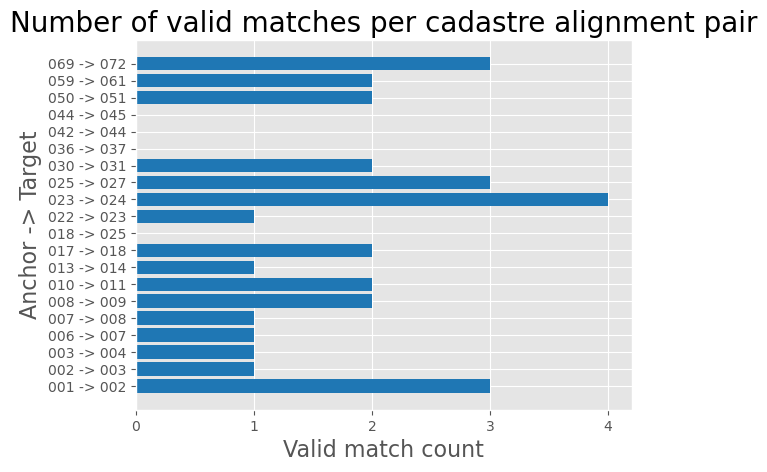

In [44]:
plt.style.use('ggplot')

argsort=np.argsort(alignmentName)

labels = np.array(alignmentName)[argsort]
indexes = np.arange(len(labels))

rescale = lambda indexes: (indexes - np.min(indexes)) / (np.max(indexes) - np.min(indexes))

plt.barh(indexes, np.array(alignmentCount)[argsort], color='tab:blue')

plt.yticks(indexes, labels)
plt.xticks(np.arange(np.max(alignmentCount)+1))

plt.xlabel('Valid match count', fontsize=16)
plt.ylabel('Anchor -> Target', fontsize=16)
plt.title('Number of valid matches per cadastre alignment pair',fontsize=20)
plt.show()

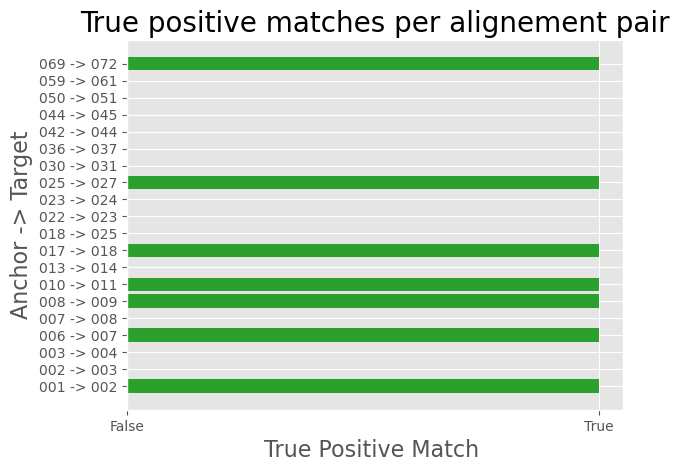

In [34]:
plt.style.use('ggplot')

argsort=np.argsort(alignmentName)

labels = np.array(alignmentName)[argsort]
indexes = np.arange(len(labels))

plt.barh(indexes, np.array(alignmentScorePositif)[argsort], color='tab:green')

plt.yticks(indexes, labels)
plt.xticks([0, 1], labels=['False', 'True'])

plt.xlabel('True Positive Match ', fontsize=16)
plt.ylabel('Anchor -> Target', fontsize=16)
plt.title('True positive matches per alignement pair',fontsize=20)
plt.show()

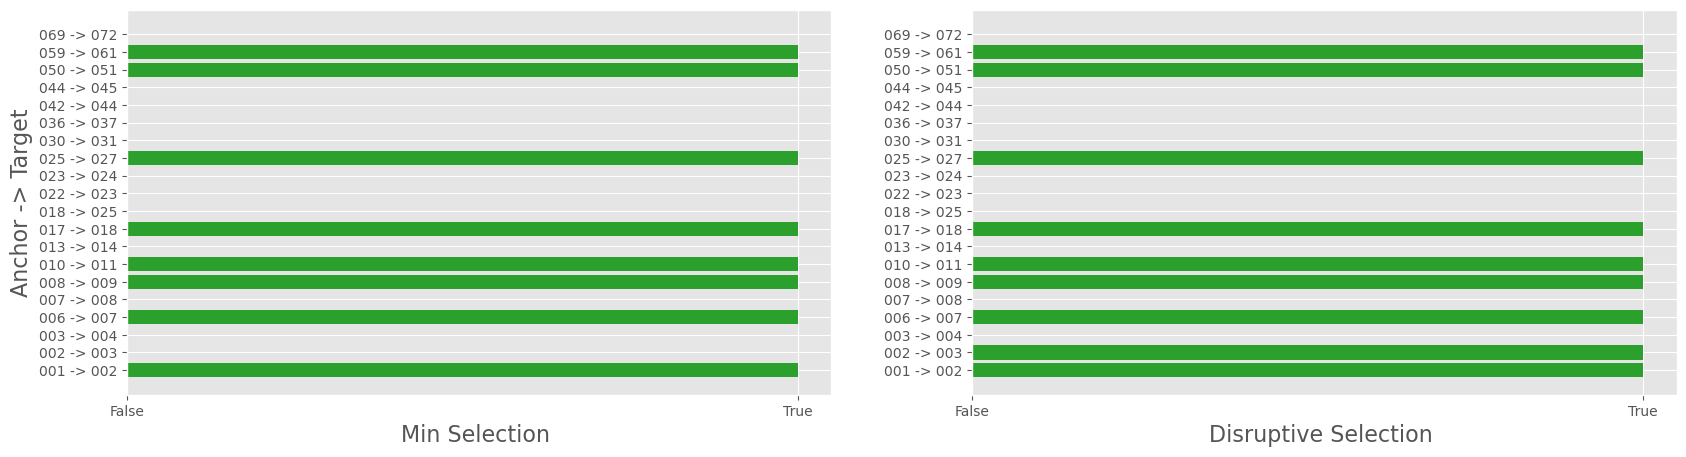

In [22]:
plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

argsort=np.argsort(alignmentName)

labels = np.array(alignmentName)[argsort]
indexes = np.arange(len(labels))

ax1.barh(indexes, np.array(alignmentScorePositif)[argsort], color='tab:green')

ax1.set_yticks(indexes, labels)
ax1.set_xticks([0, 1], labels=['False', 'True'])

ax2.barh(indexes, np.array(alignmentScoreDisruptive)[argsort], color='tab:green')

ax2.set_yticks(indexes, labels)
ax2.set_xticks([0, 1], labels=['False', 'True'])

ax1.set_xlabel('Min Selection ', fontsize=16)
ax2.set_xlabel('Disruptive Selection ', fontsize=16)
ax1.set_ylabel('Anchor -> Target', fontsize=16)
plt.show()

In [358]:
def verify_img_name(name):
    l=len(name)
    if(l==3):
        return name
    elif(l==2):
        return "0"+name
    elif(l==1):
        return "00"+name
    else:
        return "000"

In [361]:
padding=500

alignmentIoU=[]

for f in filteredFiles:
    csv_file, csv_file_model = readCSVFiles(f, filteredFilesModel)
    
    resize_factor, patch_nb, patch_size, kernel_dilate_target, times=load_csv_model(csv_file_model)
    csv_data=load_csv(csv_file)
    # READ DECOUPE
    csv_anchor_name = csv_data[0]['anchor']
    csv_target_name = csv_data[0]['target']
    
    csv_anchor_name=verify_img_name(csv_anchor_name)
    csv_target_name=verify_img_name(csv_target_name)

    csv_anchor = cv2.imread(f"../ressources/DecoupeBerney_{csv_anchor_name}.png", 0)
    csv_target = cv2.imread(f"../ressources/DecoupeBerney_{csv_target_name}.png", 0)
    csv_target = cv2.rotate(csv_target, cv2.ROTATE_90_CLOCKWISE)
    
    csv_anchor = cv2.copyMakeBorder(csv_anchor, padding, padding, padding, padding, cv2.BORDER_CONSTANT)
    csv_target = cv2.copyMakeBorder(csv_target, padding, padding, padding, padding, cv2.BORDER_CONSTANT)

    res_points_list=[]
    patch_points_list=[]
    res_score_list=np.asarray([])
    
    union = np.sum(csv_anchor)+np.sum(csv_target)
        
    for idx in range(0, 20, 1):

        score=float(csv_data[idx]['score'])
        csv_transformations = eval(csv_data[idx]['transformations'])
        tx=csv_transformations['tx']
        ty=csv_transformations['ty']
        angle=csv_transformations['angle']
        scale=csv_transformations['scale']

        top_left_corner_coordinates=csv_data[idx]['tl_pt_patch'].strip('][').split(',')
        top_left_corner_coordinates=[int(i) for i in top_left_corner_coordinates]
        
        patch_points_list.append(top_left_corner_coordinates)

        patch = patch_utils.extract_single_template(csv_anchor
                                , top_left_corner_coordinates
                                , template_w=patch_size
                                , template_h=patch_size
                               )

        tl_x, tl_y = images_combination.get_transformed_points(0, 0, patch, angle, scale)
        tl_x = int(tl_x) + tx*resize_factor
        tl_y = int(tl_y) + ty*resize_factor

        tr_x, tr_y = images_combination.get_transformed_points(patch_size, 0, patch, angle, scale)
        tr_x = int(tr_x) + tx*resize_factor
        tr_y = int(tr_y) + ty*resize_factor

        bl_x, bl_y = images_combination.get_transformed_points(0, patch_size, patch, angle, scale)
        bl_x = int(bl_x) + tx*resize_factor
        bl_y = int(bl_y) + ty*resize_factor

        br_x, br_y = images_combination.get_transformed_points((patch_size), (patch_size),
                                                  patch, angle, scale)

        br_x = int(br_x) + tx*resize_factor
        br_y = int(br_y) + ty*resize_factor
        
        _,_,_, H  = images_combination.vector_alignment(np.asarray(top_left_corner_coordinates)
                                    , np.asarray([top_left_corner_coordinates[0]+patch_size,
                                                  top_left_corner_coordinates[1]+patch_size]).astype(int)
                                    , np.asarray([tl_x, tl_y]).astype(int)
                                    , np.asarray([br_x, br_y]).astype(int)
                                    )

        warpedImages = images_combination.warpTwoImages(csv_anchor, csv_target, H)

        intersection = np.sum(warpedImages)
        IoU = intersection/union

        res_points_list.append([(tl_x, tl_y), (tr_x, tr_y), (br_x,br_y), (bl_x, bl_y)])
        res_score_list = np.append(res_score_list, (1-IoU)+score)
        
    result = ['True'==e['true_positive'] for e in csv_data]
    result=np.asarray(result)
    
    minscore=np.argmin(res_score_list)
    
    argvalid=np.argwhere(result==True)
    alignmentIoU.append(minscore in argvalid)

    #patch_utils.plot_similitude(csv_anchor, csv_target, patch_points_list, res_points_list, res_score_list, 
    #                               patch_w=patch_size, patch_h=patch_size)
    


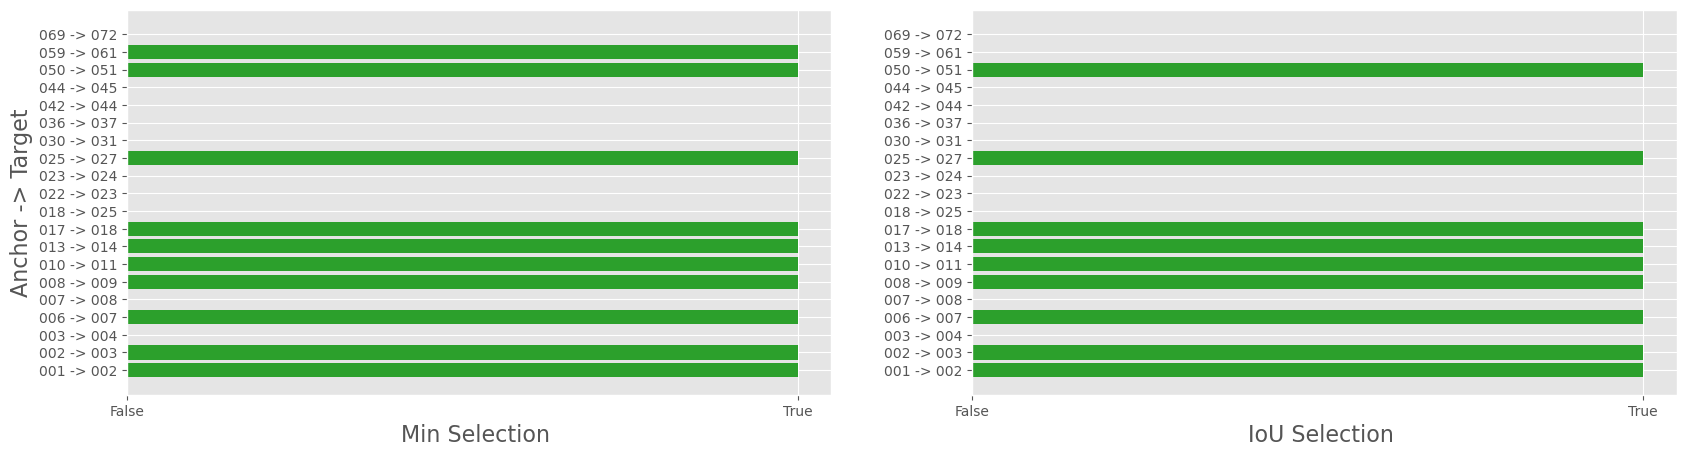

In [362]:
plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

argsort=np.argsort(alignmentName)

labels = np.array(alignmentName)[argsort]
indexes = np.arange(len(labels))

ax1.barh(indexes, np.array(alignmentScorePositif)[argsort], color='tab:green')

ax1.set_yticks(indexes, labels)
ax1.set_xticks([0, 1], labels=['False', 'True'])

ax2.barh(indexes, np.array(alignmentIoU)[argsort], color='tab:green')

ax2.set_yticks(indexes, labels)
ax2.set_xticks([0, 1], labels=['False', 'True'])

ax1.set_xlabel('Min Selection ', fontsize=16)
ax2.set_xlabel('IoU Selection ', fontsize=16)
ax1.set_ylabel('Anchor -> Target', fontsize=16)
plt.show()

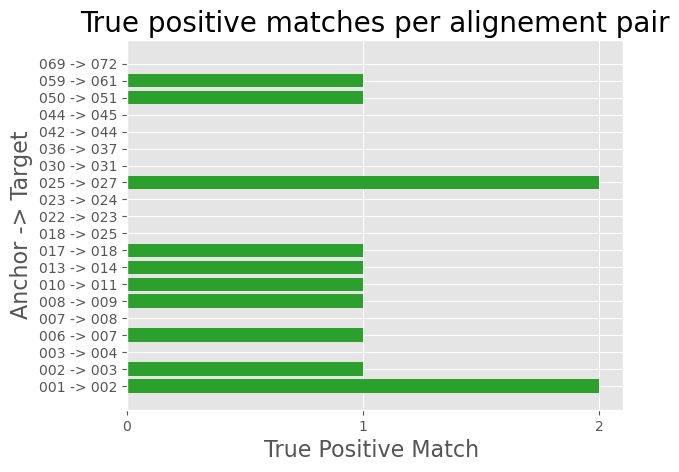

In [309]:
plt.style.use('ggplot')

argsort=np.argsort(alignmentName)

labels = np.array(alignmentName)[argsort]
indexes = np.arange(len(labels))

countA=[len(x) for x in alignmentScorePCount]

plt.barh(indexes, np.array(countA)[argsort], color='tab:green')

plt.yticks(indexes, labels)
plt.xticks(np.arange(np.max(countA)+1))

plt.xlabel('True Positive Match ', fontsize=16)
plt.ylabel('Anchor -> Target', fontsize=16)
plt.title('True positive matches per alignement pair',fontsize=20)
plt.show()

In [ ]:
csv_anchor=0
csv_target=0
padding=500

alignment_options=[]
for n in range(0, len(csv_data), patch_nb):
    alignment_n = f"{csv_data[n]['anchor']} -> {csv_data[n]['target']}" 
    alignment_options.append((alignment_n, n))

#alignment_options=["{csv_data[n]['anchor']} -> {csv_data[n]['target']}" for n in range(0, len(csv_data), patch_nb)]
#widget_alignment=widgets.Dropdown(options=[ for n in range(0, len(csv_data), patch_nb)])
widget_alignment=widgets.Dropdown(options=alignment_options)

@interact(alignment_idx=widget_alignment)
def read_image(alignment_idx=0):
    global csv_anchor
    global csv_target
    # READ DECOUPE
    csv_anchor_name = csv_data[alignment_idx]['anchor']
    csv_target_name = csv_data[alignment_idx]['target']
    
    csv_anchor_name=verify_img_name(csv_anchor_name)
    csv_target_name=verify_img_name(csv_target_name)
    
    csv_anchor = cv2.imread(f"../ressources/DecoupeBerney_{csv_anchor_name}.png", 0)
    csv_target = cv2.imread(f"../ressources/DecoupeBerney_{csv_target_name}.png", 0)
    csv_target = cv2.rotate(csv_target, cv2.ROTATE_90_CLOCKWISE)

    csv_anchor = cv2.copyMakeBorder(csv_anchor, padding, padding, padding, padding, cv2.BORDER_CONSTANT)
    csv_target = cv2.copyMakeBorder(csv_target, padding, padding, padding, padding, cv2.BORDER_CONSTANT)

widget_patch=widgets.Dropdown(options=range(0, patch_nb, 1))

def update(*args):
    new_options_value=list(range(widget_alignment.value, widget_alignment.value+patch_nb, 1))
    new_options_name=np.array(new_options_value)%20
    new_options=[]
    for i, x in enumerate(new_options_value):
        new_options.append((new_options_name[i], x))
    widget_patch.options = new_options
widget_alignment.observe(update)

@interact(idx=widget_patch)
def plot_sample(idx=0):
    #print(idx)
    score=float(csv_data[idx]['score'])
    csv_transformations = eval(csv_data[idx]['transformations'])
    tx=csv_transformations['tx']
    ty=csv_transformations['ty']
    angle=csv_transformations['angle']
    scale=csv_transformations['scale']
    
    top_left_corner_coordinates=csv_data[idx]['tl_pt_patch'].strip('][').split(',')
    top_left_corner_coordinates=[int(i) for i in top_left_corner_coordinates]
    
    tx = tx*resize_factor
    ty = ty*resize_factor
    
    patch = patch_utils.extract_single_template(csv_anchor
                            , top_left_corner_coordinates
                            , template_w=patch_size
                            , template_h=patch_size
                           )
    
    target_s, patch_m, _ = patch_utils.get_patch_composite(csv_target, patch, 
                                                           tx, ty, angle, scale)
    if patch_m is not None:
        template_red = images_utils.convert_to_rgb(patch_m, 255, 0, 0)
        plt.imshow(template_red)
        im_blue = images_utils.convert_to_rgb(target_s, 0, 0, 255)
        plt.imshow(im_blue, alpha=0.5)
    
    plt.title("score={:.2f}".format(score))
    #plt.savefig(f'../results/{csv_data[alignment_idx]['anchor']}_{csv_data[alignment_idx]['target']}_patch_{idx}.png',
    #    bbox_inches='tight')

In [ ]:
# plot individual samples
from ipywidgets import interact

@interact(alignment_idx=widget_alignment)
def read_image(alignment_idx=0):
    # READ DECOUPE
    csv_anchor_name = csv_data[alignment_idx]['anchor']
    csv_target_name = csv_data[alignment_idx]['target']
    
    csv_anchor_name=verify_img_name(csv_anchor_name)
    csv_target_name=verify_img_name(csv_target_name)

    csv_anchor = cv2.imread(f"../ressources/DecoupeBerney_{csv_anchor_name}.png", 0)
    csv_target = cv2.imread(f"../ressources/DecoupeBerney_{csv_target_name}.png", 0)
    csv_target = cv2.rotate(csv_target, cv2.ROTATE_90_CLOCKWISE)
    
    csv_anchor = cv2.copyMakeBorder(csv_anchor, padding, padding, padding, padding, cv2.BORDER_CONSTANT)
    csv_target = cv2.copyMakeBorder(csv_target, padding, padding, padding, padding, cv2.BORDER_CONSTANT)

    res_points_list=[]
    patch_points_list=[]
    res_score_list=np.asarray([])
        
    for idx in range(alignment_idx, alignment_idx+patch_nb, 1):

        score=float(csv_data[idx]['score'])
        csv_transformations = eval(csv_data[idx]['transformations'])
        tx=csv_transformations['tx']
        ty=csv_transformations['ty']
        angle=csv_transformations['angle']
        scale=csv_transformations['scale']

        top_left_corner_coordinates=csv_data[idx]['tl_pt_patch'].strip('][').split(',')
        top_left_corner_coordinates=[int(i) for i in top_left_corner_coordinates]
        
        patch_points_list.append(top_left_corner_coordinates)

        patch = patch_utils.extract_single_template(csv_anchor
                                , top_left_corner_coordinates
                                , template_w=patch_size
                                , template_h=patch_size
                               )

        tl_x, tl_y = images_combination.get_transformed_points(0, 0, patch, angle, scale)
        tl_x = int(tl_x) + tx*resize_factor
        tl_y = int(tl_y) + ty*resize_factor

        tr_x, tr_y = images_combination.get_transformed_points(patch_size, 0, patch, angle, scale)
        tr_x = int(tr_x) + tx*resize_factor
        tr_y = int(tr_y) + ty*resize_factor

        bl_x, bl_y = images_combination.get_transformed_points(0, patch_size, patch, angle, scale)
        bl_x = int(bl_x) + tx*resize_factor
        bl_y = int(bl_y) + ty*resize_factor

        br_x, br_y = images_combination.get_transformed_points((patch_size), (patch_size),
                                                  patch, angle, scale)

        br_x = int(br_x) + tx*resize_factor
        br_y = int(br_y) + ty*resize_factor

        res_points_list.append([(tl_x, tl_y), (tr_x, tr_y), (br_x,br_y), (bl_x, bl_y)])
        res_score_list = np.append(res_score_list, score)

    patch_utils.plot_similitude(csv_anchor, csv_target, patch_points_list, res_points_list, res_score_list, 
                                   patch_w=patch_size, patch_h=patch_size)

    #plt.savefig(f'../results/{csv_data[alignment_idx]['anchor']}_{csv_data[alignment_idx]['target']}.png',
    #    bbox_inches='tight')

In [ ]:
import matplotlib.gridspec as gridspec

csv_anchor=0
csv_target=0
padding=500

alignment_options=[]
for n in range(0, len(csv_data), patch_nb):
    alignment_n = f"{csv_data[n]['anchor']} -> {csv_data[n]['target']}" 
    alignment_options.append((alignment_n, n))

widget_alignment_3=widgets.Dropdown(options=alignment_options)

@interact(alignment_idx=widget_alignment_3)
def read_image(alignment_idx=0):
    global csv_anchor
    global csv_target
    # READ DECOUPE
    csv_anchor_name = csv_data[alignment_idx]['anchor']
    csv_target_name = csv_data[alignment_idx]['target']
    
    csv_anchor_name=verify_img_name(csv_anchor_name)
    csv_target_name=verify_img_name(csv_target_name)
    
    csv_anchor = cv2.imread(f"../ressources/DecoupeBerney_{csv_anchor_name}.png", 0)
    csv_target = cv2.imread(f"../ressources/DecoupeBerney_{csv_target_name}.png", 0)
    csv_target = cv2.rotate(csv_target, cv2.ROTATE_90_CLOCKWISE)

    csv_anchor = cv2.copyMakeBorder(csv_anchor, padding, padding, padding, padding, cv2.BORDER_CONSTANT)
    csv_target = cv2.copyMakeBorder(csv_target, padding, padding, padding, padding, cv2.BORDER_CONSTANT)

widget_patch_3=widgets.Dropdown(options=range(0, patch_nb, 1))

def update_3(*args):
    new_options_value=list(range(widget_alignment_3.value, widget_alignment_3.value+patch_nb, 1))
    new_options_name=np.array(new_options_value)%20
    new_options=[]
    for i, x in enumerate(new_options_value):
        new_options.append((new_options_name[i], x))
    widget_patch_3.options = new_options
widget_alignment_3.observe(update_3)

@interact(idx=widget_patch_3)
def align_2img_with_1patch(idx=0):

    plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(2, 2)
    gs.update(wspace=0.2)
    gs.update(hspace=0.1)
    ax1 = plt.subplot(gs[0, :1])
    ax2 = plt.subplot(gs[0, 1:])
    ax3 = plt.subplot(gs[1, 0:2])

    score=float(csv_data[idx]['score'])
    csv_transformations = eval(csv_data[idx]['transformations'])
    tx=csv_transformations['tx']
    ty=csv_transformations['ty']
    angle=csv_transformations['angle']
    scale=csv_transformations['scale']

    tx = tx*resize_factor
    ty = ty*resize_factor
    
    top_left_corner_coordinates=csv_data[idx]['tl_pt_patch'].strip('][').split(',')
    top_left_corner_coordinates=[int(i) for i in top_left_corner_coordinates]
    
    patch = patch_utils.extract_single_template(csv_anchor
                            , top_left_corner_coordinates
                            , template_w=patch_size
                            , template_h=patch_size
                           )

    pt1_x, pt1_y = top_left_corner_coordinates

    source=cv2.cvtColor(csv_anchor, cv2.COLOR_GRAY2RGB)
    source=cv2.circle(source, (int(pt1_x),int(pt1_y)), radius=30, color=(0, 255, 255), thickness=-1)
    source=cv2.circle(source, (int(pt1_x+patch_size),int(pt1_y+patch_size)),
                                  radius=30, color=(255, 0, 255), thickness=-1)
    ax1.imshow(source)

    pt2_x, pt2_y = images_combination.get_transformed_points(0, 0, patch, angle, scale)

    pt2_x2, pt2_y2 = images_combination.get_transformed_points((patch_size), (patch_size),
                                                  patch, angle, scale)

    dest=cv2.cvtColor(csv_target, cv2.COLOR_GRAY2RGB)
    dest=cv2.circle(dest, (int(pt2_x)+tx,int(pt2_y)+ty), radius=30, color=(0, 255, 255), thickness=-1)
    dest=cv2.circle(dest, (int(pt2_x2)+tx,int(pt2_y2)+ty),
                                  radius=30, color=(255, 0, 255), thickness=-1)
    ax2.imshow(dest)
    
    _,_,_, H  = images_combination.vector_alignment(np.asarray([int(pt1_x),int(pt1_y)]).astype(int)
                             , np.asarray([int(pt1_x)+patch_size,int(pt1_y)+patch_size]).astype(int)
                                 , np.asarray([int(pt2_x)+tx,int(pt2_y)+ty]).astype(int)
                                 , np.asarray([int(pt2_x2)+tx,int(pt2_y2)+ty]).astype(int)
                                )

    warpedImages = images_combination.warpTwoImages(csv_anchor, csv_target, H)
    
    ax3.imshow(warpedImages, cmap='Greys')

In [ ]:
csv_anchor=0
csv_target=0
padding=500

alignment_options=[]
for n in range(0, len(csv_data), patch_nb):
    alignment_n = f"{csv_data[n]['anchor']} -> {csv_data[n]['target']}" 
    alignment_options.append((alignment_n, n))

widget_alignment_4=widgets.Dropdown(options=alignment_options)

@interact(alignment_idx=widget_alignment_4)
def read_image(alignment_idx=0):
    global csv_anchor
    global csv_target
    # READ DECOUPE
    csv_anchor_name = csv_data[alignment_idx]['anchor']
    csv_target_name = csv_data[alignment_idx]['target']
    
    csv_anchor_name=verify_img_name(csv_anchor_name)
    csv_target_name=verify_img_name(csv_target_name)
    
    csv_anchor = cv2.imread(f"../ressources/DecoupeBerney_{csv_anchor_name}.png", 0)
    csv_target = cv2.imread(f"../ressources/DecoupeBerney_{csv_target_name}.png", 0)
    csv_target = cv2.rotate(csv_target, cv2.ROTATE_90_CLOCKWISE)

    csv_anchor = cv2.copyMakeBorder(csv_anchor, padding, padding, padding, padding, cv2.BORDER_CONSTANT)
    csv_target = cv2.copyMakeBorder(csv_target, padding, padding, padding, padding, cv2.BORDER_CONSTANT)

widget_patch_4=widgets.Dropdown(options=range(0, patch_nb, 1))

def update4(*args):
    new_options_value=list(range(widget_alignment_4.value, widget_alignment_4.value+patch_nb, 1))
    new_options_name=np.array(new_options_value)%20
    new_options=[]
    for i, x in enumerate(new_options_value):
        new_options.append((new_options_name[i], x))
    widget_patch_4.options = new_options
widget_alignment_4.observe(update4)

@interact(idx=widget_patch_4)
def align_2img_with_1patch(idx=0):

    plt.figure(figsize=(10,10))

    score=float(csv_data[idx]['score'])
    csv_transformations = eval(csv_data[idx]['transformations'])
    tx=csv_transformations['tx']
    ty=csv_transformations['ty']
    angle=csv_transformations['angle']
    scale=csv_transformations['scale']

    tx = tx*resize_factor
    ty = ty*resize_factor
    
    top_left_corner_coordinates=csv_data[idx]['tl_pt_patch'].strip('][').split(',')
    top_left_corner_coordinates=[int(i) for i in top_left_corner_coordinates]
    
    patch = patch_utils.extract_single_template(csv_anchor
                            , top_left_corner_coordinates
                            , template_w=patch_size
                            , template_h=patch_size
                           )

    pt1_x, pt1_y = top_left_corner_coordinates

    pt2_x, pt2_y = images_combination.get_transformed_points(0, 0, patch, angle, scale)

    pt2_x2, pt2_y2 = images_combination.get_transformed_points((patch_size), (patch_size),
                                                      patch, angle, scale)

    pt2_x3, pt2_y3 = images_combination.get_transformed_points((0), (patch_size),
                                                  patch, angle, scale)

    pt2_x4, pt2_y4 = images_combination.get_transformed_points((patch_size), (0),
                                                  patch, angle, scale)

    points1 = np.asarray([[pt1_x, pt1_y],
                          [pt1_x+patch_size, pt1_y+patch_size],
                          [pt1_x, pt1_y+patch_size],
                          [pt1_x+patch_size, pt1_y]])

    #points1[:, [0, 1]] = points1[:, [1, 0]]

    points2 = np.asarray([[pt2_x+tx, pt2_y+ty],
                          [pt2_x2+tx, pt2_y2+ty],
                          [pt2_x3+tx, pt2_y3+ty],
                          [pt2_x4+tx, pt2_y4+ty]])

    #points2[:, [0, 1]] = points2[:, [1, 0]]

    h, sta = cv2.findHomography(points2, points1, cv2.RANSAC, 5.0)

    warpedImages = images_combination.warpTwoImages(csv_anchor, csv_target, h)

    plt.figure(figsize=(10,10))
    plt.imshow(warpedImages, cmap='gray')